In [56]:
import sys
import matplotlib.pyplot as plt
import scipy.io as sio

sys.path.insert(0, '/Users/jogal/Desktop/extended_paper_code/')


from network1 import *

# System Parameters

In [150]:
def cost_func(theta,lamb,n_ab,Permut,N,M,To_phi, Tm_phi, T_gamma, W2, xo):

    m = (N*M)
    A1 = gen_A1(theta,n_ab,Permut,N)

    Phi_o = A1@To_phi
    Phi_m = A1@Tm_phi
    Gamma = A1@T_gamma

    Phi = jnp.block([Phi_o,Phi_m])
        
    bar_xo2 = W2.T@xo
    

    Phi_xo_Gamma = Phi_o@bar_xo2+Gamma
    L_PhiSquared = linalg.cholesky(Phi.T@Phi)
    ln_det_PhiSquared = 2*(jnp.log(jnp.diag(L_PhiSquared))).sum()


    Z = Phi_m.T@Phi_m
    #P = np.eye(Phi_m.shape[0]) - Phi_m@jnp.linalg.inv(Z)@Phi_m.T                                                   #previous code with inverse computation
    PxPhi_xo_Gamma = Phi_xo_Gamma - Phi_m@jnp.linalg.solve(Z,Phi_m.T@Phi_xo_Gamma)
    
    
    L_Z = linalg.cholesky(Z)
    ln_det_Z = 2*(jnp.log(jnp.diag(L_Z))).sum()
    return jnp.sum((1/2)*Phi_xo_Gamma.T@PxPhi_xo_Gamma+(m/2)*jnp.log(lamb)-(1/2)*ln_det_PhiSquared+(1/2)*ln_det_Z)
    #return jnp.sum((1/2)*Phi_xo_Gamma.T@PxPhi_xo_Gamma)
    #return jnp.sum(-(1/2)*ln_det_PhiSquared+(1/2)*ln_det_Z)
    #return jnp.sum(-(1/2)*ln_det_PhiSquared)
    #return jnp.sum((1/2)*ln_det_Z)




grad_theta = grad(cost_func, argnums=0)

lamb= 0.1

In [151]:
Hessian = jacfwd(lambda theta,lamb,n_ab, Permut, N, M, To_phi, Tm_phi, T_gamma, W2, xo, sproper=False : grad_theta(theta,lamb,n_ab, Permut, N, M, To_phi, Tm_phi, T_gamma, W2, xo),argnums=0)


In [152]:
big_net1 = sio.loadmat("./big_net1.mat")
big_net2 = sio.loadmat("./big_net2.mat")

In [153]:
########## System parameters

#n_ab = np.array([[1,1,1,1,1,1,1,1,1,1],[2,2,2,2,2,2,2,2,2,2]]) #n_ab = [[na1,na2,na3],[nb1,nb2,nb3]]
n_ab = np.array([[1,1,1,1,1,1,1,1,1,1],[1,1,1,1,1,1,1,1,1,1]])

M = n_ab.shape[1] #number of systems
N = 50 #number of samples;
sigma = 0.1  #noise standard deviation
lam = 0.1


#Interconections
Lamb = jnp.array([[0,1,1,0,0,0,0,0,0,0],
                  [1,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,0,1,1],
                  [0,0,0,0,0,0,0,0,1,1],
                  [0,0,0,0,1,0,1,0,0,0],
                  [0,0,0,1,0,1,0,0,0,0],
                  [0,0,0,0,1,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1,0,0],
                  [1,0,0,0,0,0,0,0,0,0],
                 ])
Delta = jnp.array([[1,0,0],
                   [0,1,0],
                   [0,0,1],
                   [0,0,0],
                   [0,0,0],
                   [0,0,0],
                   [0,0,0],
                   [0,0,0],
                   [0,0,1],
                   [0,1,0],
                 ])


obs = [1,2,8]#[1,2,8,10]#[1,2,8,10,4,6,7]
n_obs = len(obs)
    

########## Gen data:
r_single_exp = big_net1["r"]
r_sig = r_single_exp.reshape(-1,1)
x = big_net1["x"]
xo = np.random.rand(N*n_obs).reshape(-1,1)

xo,_,Permut = get_xoxm(x,obs,N,M)



A2,B2 = gen_A2B2(Lamb,Delta,Permut,M,N,r_sig)
A2o = A2[:,:n_obs*N]
A2m = A2[:,n_obs*N:]
To_phi, Tm_phi, T_gamma, W2, V2 = get_transform_matrices(A2o,A2m,B2)

In [154]:
theta_ex = big_net1["theta"].T#[:10]

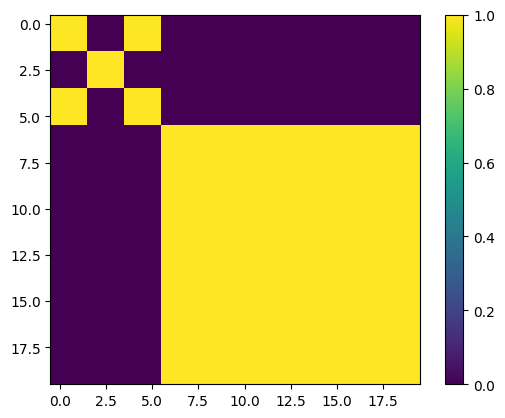

In [155]:
H = Hessian(theta_ex,lamb,n_ab, Permut, N, M, To_phi, Tm_phi, T_gamma, W2, xo).reshape(theta_ex.shape[0],theta_ex.shape[0])
plt.imshow(np.abs(H)>0.0000001)
plt.colorbar()

In [156]:
H_1 = H.copy()

In [157]:
#theta_ex[0:6,:]=1.1*theta_ex[0:6,:]

theta_ex[6:14,:]=1.2*theta_ex[6:14,:]

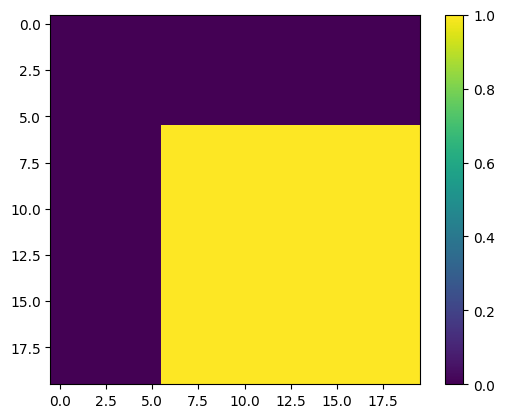

In [158]:
H = Hessian(theta_ex,lamb,n_ab, Permut, N, M, To_phi, Tm_phi, T_gamma, W2, xo,True).reshape(theta_ex.shape[0],theta_ex.shape[0])
plt.imshow(np.abs(H-H_1)>0.0000001)
plt.colorbar()

In [132]:
theta_ex

array([[-0.67563538],
       [ 0.58856908],
       [-0.37756992],
       [ 0.05706627],
       [-0.66870254],
       [ 0.20396388],
       [-0.56886892],
       [ 0.36978984],
       [ 0.45411481],
       [ 0.59556382],
       [-0.11870016],
       [-0.99882869],
       [-0.65045528],
       [ 0.99200967],
       [-0.69524396],
       [ 0.65163395],
       [ 0.07668487],
       [ 0.99226943],
       [-0.84364894],
       [-0.11464346]])

### Visualizing the matrices

In [84]:
A1 = gen_A1(theta_ex,n_ab,Permut,N)

Phi_o = A1@To_phi
Phi_m = A1@Tm_phi
Gamma = A1@T_gamma

Phi = jnp.block([Phi_o,Phi_m])


U,S,V = np.linalg.svd(A2m,full_matrices=True)
V = V.T
m2,no = A2o.shape
_,nm = A2m.shape
m21 = len(S)
nm1 = m21
m22 = m2-m21
nm2 = nm - nm1
U1 = U[:,:m21]
U2 = U[:,m21:]
V1 = V[:,:nm1]
V2 = V[:,nm1:]

Sigma1 = np.diag(S)
barA2o2 = U2.T@A2o

W,R = np.linalg.qr(barA2o2.T,mode="complete")
try:
    nW1 = np.linalg.matrix_rank(R)
except:
    nW1 = 0
nW2 = no - nW1

W1 = W[:,:nW1]
W2 = W[:,nW1:]

hatA2m = V1@np.linalg.pinv(Sigma1)@U1.T

Y1 = W1@np.linalg.pinv(U2.T@A2o@W1)@U2.T

To_phi = np.block([[np.eye(no)],[-hatA2m@A2o]])@W2
Tm_phi = np.block([[np.zeros((no,nm2))],[V2]])
T_gamma = np.block([[-Y1@B2], [hatA2m@(A2o@Y1 - np.eye(m2))@B2]]);

plt.imshow(np.abs(A1)>0.00001)


In [85]:
Z = Phi_m.T@Phi_m
P = np.eye(Phi_m.shape[0]) - Phi_m@jnp.linalg.inv(Z)@Phi_m.T

cov_inv = Phi_o.T@P@Phi_o

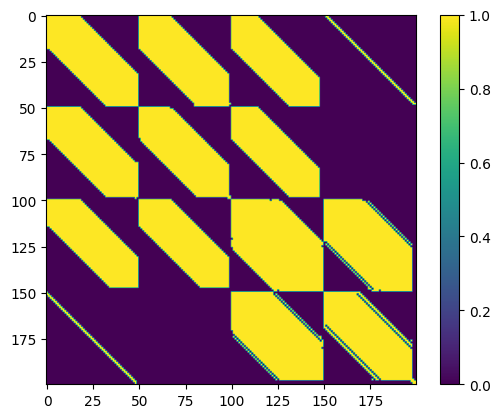

In [86]:
plt.imshow(np.abs(cov_inv)>0.0000001)
plt.colorbar()

In [87]:
5*M, Phi_o.shape

(50, (500, 200))

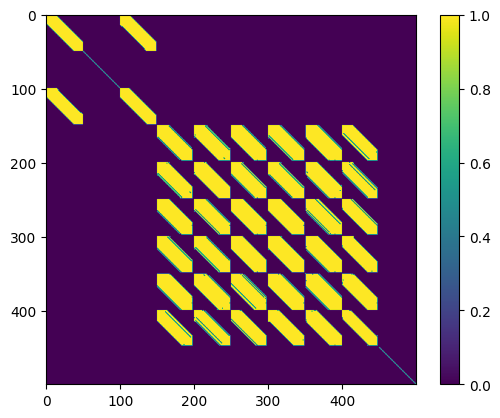

In [88]:
plt.imshow(np.abs(P)>0.00001)
plt.colorbar()

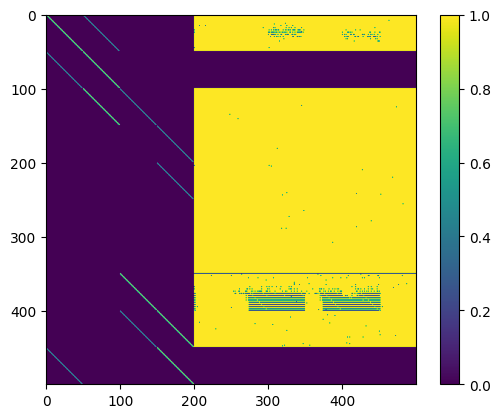

In [89]:
plt.imshow(np.abs(Phi)>0.00001)
plt.colorbar()

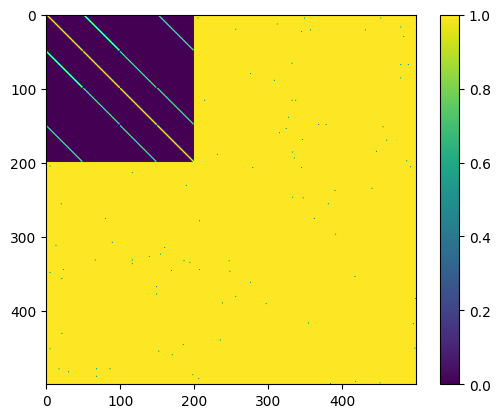

In [90]:
plt.imshow(np.abs(Phi.T@Phi)>0.00001)
plt.colorbar()

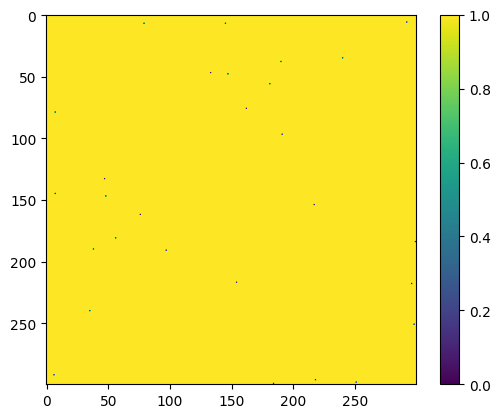

In [91]:
plt.imshow(np.abs(Z)>0.00001)
plt.colorbar()

In [92]:
np.log(np.linalg.det(Phi.T@Phi)),np.log(np.linalg.det(Phi_m.T@Phi_m))

(-224.99048351651504, -142.18140626492547)

In [93]:
#Interconections
Lamb = jnp.array([[0,1,0,1],
                  [1,0,0,0],
                  [1,0,0,0],
                  [0,0,0,0],
                 ])
Delta = jnp.array([[1,0,0],
                   [0,1,0],
                   [0,1,0],
                   [0,0,1],
                 ])

big_net = sio.loadmat('big_net1.mat')

initial_theta = sio.loadmat('big_net2.mat')["theta"]


In [94]:
x_big_net = big_net["x"]
x = np.block([[x_big_net[:N*4]],[x_big_net[N*10:N*14]]]) # x_sub_net = [y1 y2 y3 y4 u1 u2 u3 u4]

r_single_exp = big_net["r"]



In [95]:
r_single_exp[:,2] = x_big_net[N*7:N*8].reshape(-1)+r_single_exp[:,2]

In [96]:
r_single_exp[:,2]-x[N*7:].reshape(-1)

array([ 0.36344391,  1.6967099 ,  1.57684193, -0.28657252,  2.00618818,
       -0.47425453, -0.99791847, -1.18786143,  2.44260813, -0.50256688,
        3.12074241, -1.06269639, -0.92593256,  3.21596898,  1.81823828,
        3.96508203,  2.02858803,  1.68662723,  1.1238675 , -3.05358054,
       -0.79542443, -1.38337262, -1.91057783, -0.25674489,  0.58973845,
        0.75925394,  0.45351228, -0.46420556, -0.23866607, -0.42917056,
       -0.79668661,  1.3226696 ,  1.31198829,  2.7047368 , -2.02864401,
       -0.08408894, -1.97903398, -1.22200404, -1.39031139, -1.71356491,
       -2.13754058, -2.31128215, -0.33046432, -2.51753314, -0.8656549 ,
       -0.01150464, -0.674385  , -0.31492501, -0.15008398,  2.03872078])